In [1]:
# Import packgets
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
# Merging data
data_path = './Data'
data_list = os.listdir(data_path)
for i in range(len(data_list)):
    temp_path = data_path + '/' + data_list[i]
    if i == 0:
        raw_data = pd.read_csv(temp_path)  
    else:
        temp_data = pd.read_csv(temp_path)
        raw_data = pd.concat([raw_data, temp_data], axis=0)


In [3]:
#Data cleaning
data = raw_data.drop('Unnamed: 0', axis=1)
data = data[~(data['Unit'] != 'pounds')]
data['Luggage'] = data['Luggage'].replace({False: 0})
data['Luggage'] = data['Luggage'].replace({True: 1})
data['Stops'] = data['Stops'].str.replace('Nonstop', '0')
data['Stops'] = data['Stops'].str.replace('Direct', '0')

def convert_ampm(value):
    if 'AM' in value:
        # 提取数字部分并转换为整数
        return value.replace('AM', '')
    else:
        temp = value.replace('PM', '')
        temp = temp.split(':')
        temp_hour = int(temp[0])+12
        if temp_hour == 24:
            value = '00:'+temp[1]
        else:
            value = str(temp_hour)+':'+temp[1]
        return value
data['Depart'] = data['Depart'].apply(convert_ampm)
data['Arrive'] = data['Arrive'].apply(convert_ampm)
data['Depart'] = pd.to_datetime(data['Depart'], format='%H:%M')
data['Arrive'] = pd.to_datetime(data['Arrive'], format='%H:%M')
data['Duration'] = data.apply(lambda row: (row['Arrive'] - row['Depart']).total_seconds() / 60, axis=1)
def add_1440_if_negative(value):
    if value < 0:
        return value + 1440
    else:
        return value
data['Duration'] = data['Duration'].apply(add_1440_if_negative)
data['FlightDate'] = pd.to_datetime(data['FlightDate'])
data['CheckDate'] = pd.to_datetime(data['CheckDate'])
data['CheckDuration'] = (data['FlightDate'] - data['CheckDate']).dt.days

distance = pd.read_csv('Airport.csv')
City = list(distance["City"])
Distance = list(distance["Distance"])
temp_dict = {}
for i in range(len(City)):
    temp_dict[(City[i],'London')] = Distance[i]
def merge_distance(row):
    lookup_key1 = (row['Start'], row['Destination'])
    lookup_key2 = (row['Destination'], row['Start'])
    new_value = temp_dict.get(lookup_key1) or temp_dict.get(lookup_key2, 'default_value')
    return new_value
data['Distance'] = data.apply(merge_distance, axis=1)
data['Distance'] = data['Distance'].astype(float)
data

,Price,Unit,Luggage,Stops,Airline,Depart,Arrive,Start,Destination,FlightDate,CheckDate,Duration,CheckDuration,Distance
0,63,pounds,1,1,Scandinavian Airlines. Operated by Sas Connect,1900-01-01 08:00:00,1900-01-01 14:35:00,Alesund,London,2023-10-17,2023-06-29,395.0,110,1278.46
1,63,pounds,1,1,Scandinavian Airlines. Operated by Sas Connect,1900-01-01 14:15:00,1900-01-01 18:30:00,Alesund,London,2023-10-17,2023-06-29,255.0,110,1278.46
2,63,pounds,1,1,Scandinavian Airlines. Operated by Sas Connect,1900-01-01 18:25:00,1900-01-01 21:35:00,Alesund,London,2023-10-17,2023-06-29,190.0,110,1278.46
3,71,pounds,1,2,"Scandinavian Airlines. Operated by Sas Link, S...",1900-01-01 08:35:00,1900-01-01 14:35:00,Alesund,London,2023-10-17,2023-06-29,360.0,110,1278.46
4,88,pounds,0,1,Norwegian,1900-01-01 16:35:00,1900-01-01 20:05:00,Alesund,London,2023-10-17,2023-06-29,210.0,110,1278.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,117,pounds,1,1,LOT,1900-01-01 18:10:00,1900-01-01 17:40:00,London,Plovdiv,2024-02-17,2024-01-15,1410.0,33,2146.93
2197,121,pounds,0,0,Wizz Air,1900-01-01 08:45:00,1900-01-01 13:55:00,London,Plovdiv,2024-02-17,2024-01-15,310.0,33,2146.93
2198,122,pounds,1,2,SWISS and Lufthansa,1900-01-01 18:50:00,1900-01-01 13:00:00,London,Plovdiv,2024-02-17,2024-01-15,1090.0,33,2146.93
2199,124,pounds,0,2,"British Airways, Vueling and Wizz Air",1900-01-01 19:20:00,1900-01-01 15:00:00,London,Plovdiv,2024-02-17,2024-01-15,1180.0,33,2146.93


In [4]:
train_data = data.drop('Unit', axis=1)
train_data = train_data.drop('Start', axis=1)
train_data = train_data.drop('Destination', axis=1)
train_data = train_data.drop('CheckDate', axis=1)
train_data = train_data.drop('Arrive', axis=1)

train_data['FlightDate'] = pd.to_datetime(train_data['FlightDate'])
train_data['year'] = train_data['FlightDate'].dt.year
train_data['month'] = train_data['FlightDate'].dt.month
train_data['day'] = train_data['FlightDate'].dt.day
train_data['day_of_week'] = train_data['FlightDate'].dt.dayofweek
train_data = train_data.drop('FlightDate', axis=1)

train_data['hours'] = train_data['Depart'].apply(lambda x: x.hour)
train_data['minutes'] = train_data['Depart'].apply(lambda x: x.minute)
train_data['sin_time'] = np.sin(2 * np.pi * (train_data['hours'] * 60 + train_data['minutes'] * 60) / (24 * 60))
train_data['cos_time'] = np.cos(2 * np.pi * (train_data['hours'] * 60 + train_data['minutes'] * 60) / (24 * 60))
train_data = train_data.drop('Depart', axis=1)

data_one_hot = pd.get_dummies(train_data['Airline'])
train_data = train_data.drop('Airline', axis=1)
train_data = pd.concat([train_data, data_one_hot], axis=1)

train_data

,Price,Luggage,Stops,Duration,CheckDuration,Distance,year,month,day,day_of_week,...,"easyJet, Jet2 and Vueling","easyJet, KLM and Bulgaria Air","easyJet, KLM, Singapore Airlines and Aer Lingus","easyJet, Transavia and Wizz Air","easyJet, Vueling and Olympic","easyJet, Wizz Air and Finnair","easyJet, Wizz Air and Jet2","easyJet, Wizz Air and LOT","easyJet, Wizz Air and SKY express","easyJet, Wizz Air and Vueling"
0,63,1,1,395.0,110,1278.46,2023,10,17,1,...,False,False,False,False,False,False,False,False,False,False
1,63,1,1,255.0,110,1278.46,2023,10,17,1,...,False,False,False,False,False,False,False,False,False,False
2,63,1,1,190.0,110,1278.46,2023,10,17,1,...,False,False,False,False,False,False,False,False,False,False
3,71,1,2,360.0,110,1278.46,2023,10,17,1,...,False,False,False,False,False,False,False,False,False,False
4,88,0,1,210.0,110,1278.46,2023,10,17,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,117,1,1,1410.0,33,2146.93,2024,2,17,5,...,False,False,False,False,False,False,False,False,False,False
2197,121,0,0,310.0,33,2146.93,2024,2,17,5,...,False,False,False,False,False,False,False,False,False,False
2198,122,1,2,1090.0,33,2146.93,2024,2,17,5,...,False,False,False,False,False,False,False,False,False,False
2199,124,0,2,1180.0,33,2146.93,2024,2,17,5,...,False,False,False,False,False,False,False,False,False,False


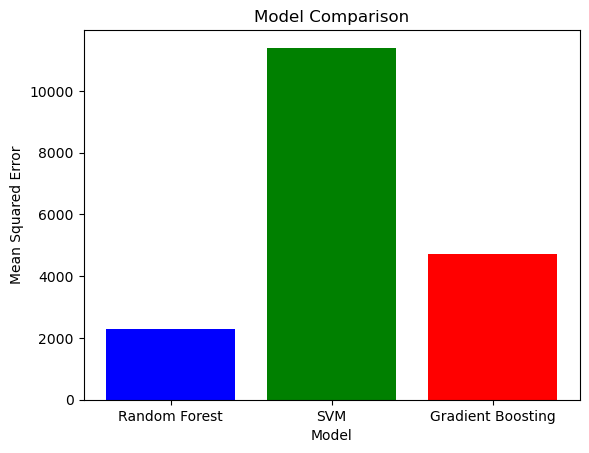

In [5]:
X = train_data.drop('Price', axis=1)
y = train_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor(random_state=42)
svm_model = SVR()
gb_model = GradientBoostingRegressor(random_state=42)

rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)


rf_pred = rf_model.predict(X_test)
svm_pred = svm_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
svm_mse = mean_squared_error(y_test, svm_pred)
gb_mse = mean_squared_error(y_test, gb_pred)


models = ['Random Forest', 'SVM', 'Gradient Boosting']
mse_values = [rf_mse, svm_mse, gb_mse]

plt.bar(models, mse_values, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Model Comparison')
plt.show()